In [1]:
import os
from pathlib import Path

import numpy as np
from edpyt.espace import build_espace, screen_espace
from edpyt.gf2_lanczos import build_gf2_lanczos
from edpyt.shared import params
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/run1'
os.chdir(new_path)


/users/ajayaraj/miniconda3/envs/qtpyt/lib/python3.9/site-packages/numba/cpython/hashing.py:524: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


In [5]:
class Sigma:

    def __init__(self, gf, H_eff, eta=1e-5):
        self.gf = gf
        self.eta = eta
        self.H_eff = H_eff

    def retarded(self, energy):
        energies = np.atleast_1d(energy)
        g = self.gf(energies, self.eta)
        sigma = np.empty((energies.size,self.gf.n,self.gf.n), complex)
        for e, energy in enumerate(energies):
            sigma[e] = energy - self.H_eff - np.linalg.inv(g[...,e])
        return sigma


In [ ]:
path = Path('/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/run1/output/lowdin')
H_eff = np.load(path/'effective_hamiltonian.npy')
nimp = H_eff.shape[0]
occupancy_goal = np.load(path/'occupancies_38.68.npy')

In [ ]:
de = 0.01
energies = np.arange(-3, 3 + de / 2.0, de).round(7)
eta = 1e-3
beta = 38.68
params['z'] = occupancy_goal

In [3]:
V = np.loadtxt(path/'U_matrix.txt')
DC = np.diag(V.diagonal()*(occupancy_goal-0.5))
neig = np.ones((nimp+1)*(nimp+1),int) * 4

In [7]:
espace, egs = build_espace(H_eff, np.zeros_like(H_eff), neig_sector=neig)
screen_espace(espace, egs, beta)
gf0 = build_gf2_lanczos(H_eff, np.zeros_like(H_eff), espace, beta, egs)
DOS0 = -1/np.pi * gf0(energies, eta).imag.trace(axis1=0,axis2=1)

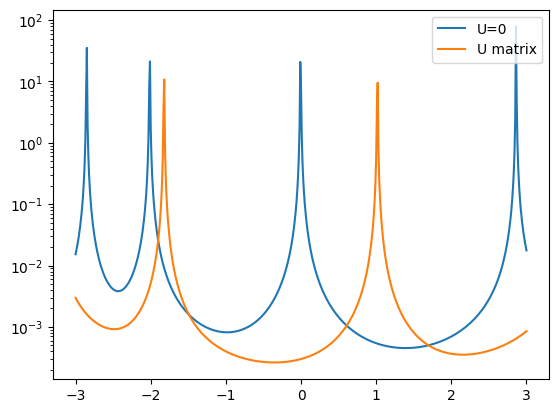

In [8]:
espace, egs = build_espace(H_eff-DC, V, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff-DC, V, espace, beta, egs)
DOS = -1/np.pi * gf(energies, eta).imag.trace(axis1=0,axis2=1)

plt.plot(energies, DOS0, label="U=0")
plt.plot(energies, DOS, label="U matrix")
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
sigma = Sigma(gf, H_eff, eta=eta)
sig = sigma.retarded(energies)
output_path = Path('/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/run1/output/lowdin/ed')
np.save(output_path/'ed_sigma.npy', sig)
sig = np.load(output_path/'ed_sigma.npy')
sig_trace = np.trace(sig,axis1=1,axis2=2)

In [10]:
ref = np.loadtxt("/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/reference/sigma_ed_uii_trace.txt")
ref_energy = ref[:,0]
ref_real = ref[:,1]
ref_imag = ref[:,2]

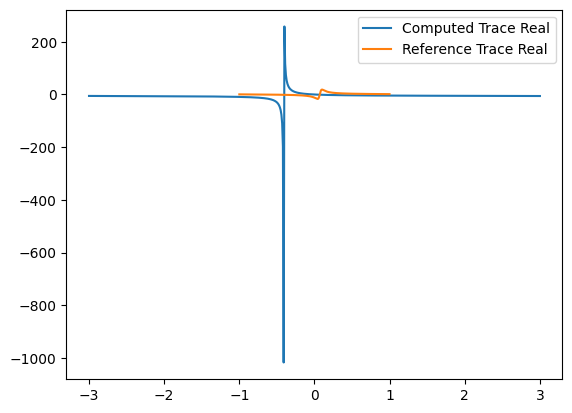

Real part peak positions (computed): [-0.4]
Real part dip positions (computed): [-0.41]


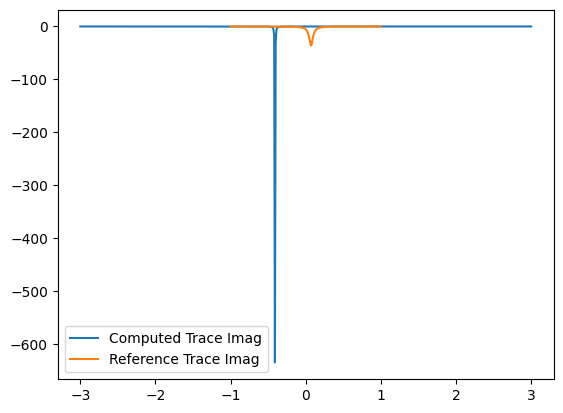

Imaginary part peak positions (computed): [-2.63  2.4 ]
Imaginary part dip positions (computed): [-0.41]


In [11]:
# Plot the real part of the trace
plt.plot(energies, sig_trace.real, label="Computed Trace Real")
plt.plot(ref_energy, ref_real, label="Reference Trace Real")
# plt.ylim(-10, 10)
# plt.xlim(-1,0.5)
plt.legend()
plt.show()

# Find and print peaks and dips for the real part of the computed trace
real_peaks, _ = find_peaks(sig_trace.real)
real_dips, _ = find_peaks(-sig_trace.real)
real_peak_positions = energies[real_peaks]
real_dip_positions = energies[real_dips]
print("Real part peak positions (computed):", real_peak_positions)
print("Real part dip positions (computed):", real_dip_positions)

# Plot the imaginary part of the trace
plt.plot(energies, sig_trace.imag, label="Computed Trace Imag")
plt.plot(ref_energy, ref_imag, label="Reference Trace Imag")
# plt.ylim(-10, 10)
plt.legend()
plt.show()

# Find and print peaks and dips for the imaginary part of the computed trace
imag_peaks, _ = find_peaks(sig_trace.imag)
imag_dips, _ = find_peaks(-sig_trace.imag)
imag_peak_positions = energies[imag_peaks]
imag_dip_positions = energies[imag_dips]
print("Imaginary part peak positions (computed):", imag_peak_positions)
print("Imaginary part dip positions (computed):", imag_dip_positions)


In [16]:
from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy
from qtpyt.projector import expand


class DataSelfEnergy(BaseDataSelfEnergy):
    """Wrapper"""

    def retarded(self, energy):
        return expand(S_molecule_identity, super().retarded(energy), idx_molecule)


def load(filename):
    ed = np.load(filename)
    print(ed.shape)
    return DataSelfEnergy(energies, np.load(filename))

In [17]:
data_folder = "output/lowdin"
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
nodes = [0, 810, 1116, 1278, 1584, 2394]
imb = 2
S_molecule_identity = np.eye(9)
idx_molecule = (
    index_active_region - nodes[imb]
)  # indices of active region w.r.t molecule


In [18]:
ed_data_folder = "output/lowdin/ed"
ed_sigma_file = f"{ed_data_folder}/ed_sigma.npy"
ed_sigma = load(ed_sigma_file)


(601, 9, 9)


In [43]:
dmft = load("/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/run1/output/lowdin/dmft/no_spin/dmft_sigma.npy")

(601, 9, 9)


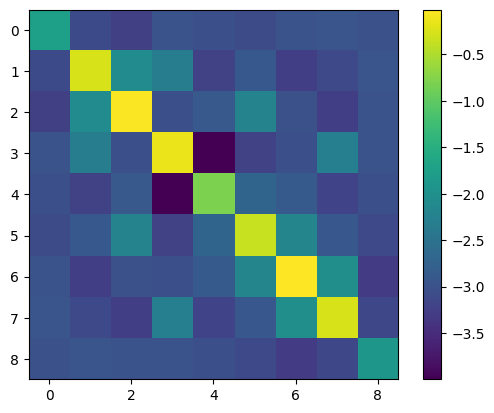

In [50]:
ed = np.load(ed_sigma_file)
plt.imshow(ed.real[0])
plt.colorbar()
plt.show()

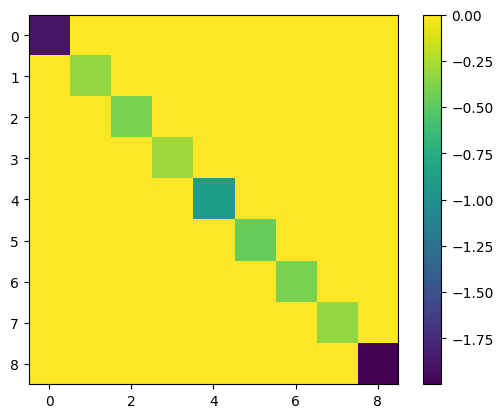

In [49]:
dmft = np.load("/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/run1/output/lowdin/dmft/no_spin/dmft_sigma.npy")
plt.imshow(dmft.real[100])
plt.colorbar()
plt.show()
